In [1]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
# from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
image_path = "C:\\Users\\R SHREYA\\Desktop\\Mini project\\Flickr8k_Dataset/Flicker8k_Dataset"
dir_Flickr_text = "C:\\Users\\R SHREYA\\Desktop\\Mini project\\Flickr8k_Dataset/Flickr8k_text/Flickr8k.token.txt"
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 16183


In [3]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split('\t')
   if len(col) == 1:
       continue
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)


In [4]:
data.head()

,index,filename,caption
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40455 entries, 0 to 40459
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     40455 non-null  object
 1   filename  40455 non-null  object
 2   caption   40455 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


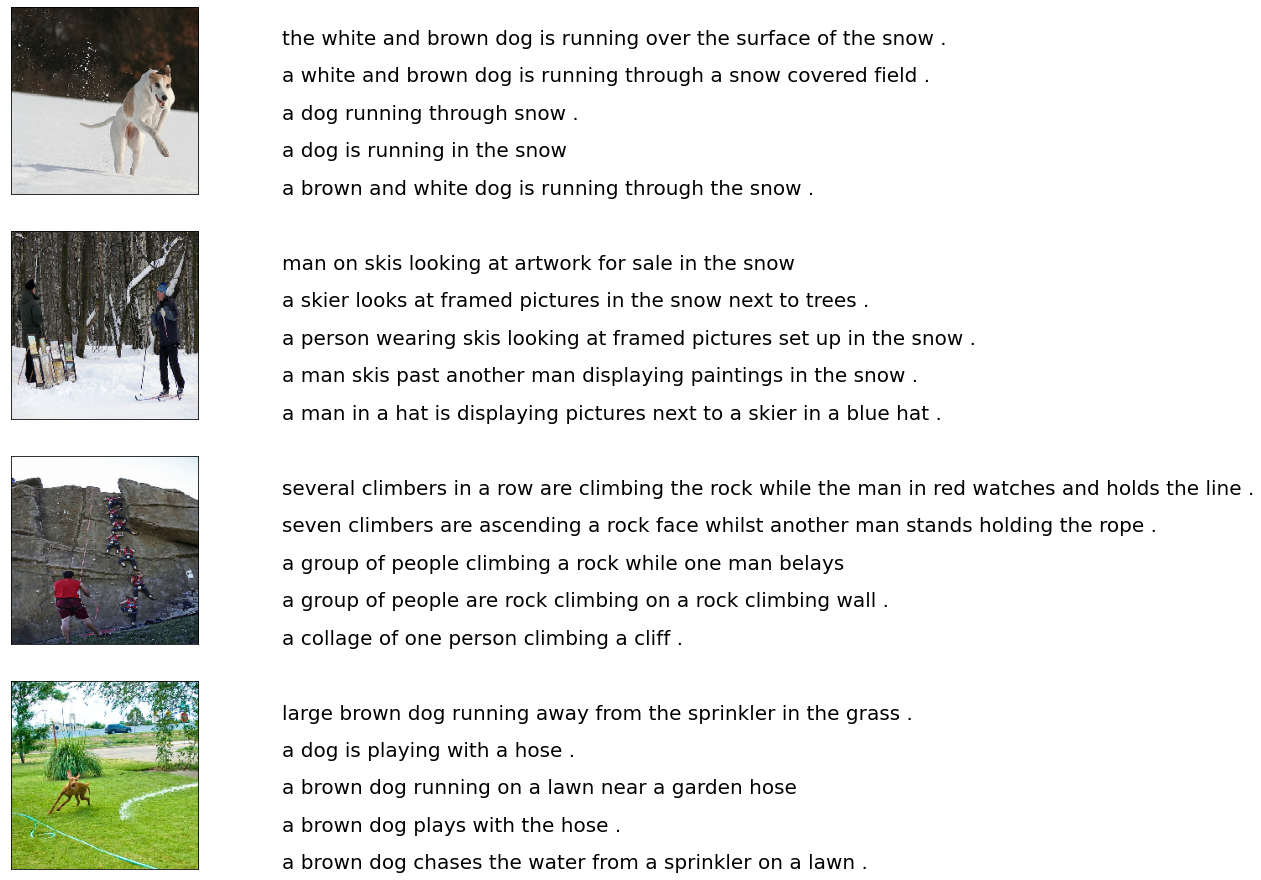

In [6]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
   filename = image_path + '/' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

In [7]:
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8918


In [8]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)
def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

In [9]:
clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8357


In [10]:
PATH = "C:\\Users\\R SHREYA\\Desktop\\Mini project\\Flickr8k_Dataset/Flicker8k_Dataset/"
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [11]:
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['C:\\Users\\R SHREYA\\Desktop\\Mini project\\Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'C:\\Users\\R SHREYA\\Desktop\\Mini project\\Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'C:\\Users\\R SHREYA\\Desktop\\Mini project\\Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'C:\\Users\\R SHREYA\\Desktop\\Mini project\\Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'C:\\Users\\R SHREYA\\Desktop\\Mini project\\Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'C:\\Users\\R SHREYA\\Desktop\\Mini project\\Flickr8k_Dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'C:\\Users\\R SHREYA\\Desktop\\Mini project\\Flickr8k_Dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'C:\\Users\\R SHREYA\\Desktop\\Mini project\\Flickr8k_Dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'C:\\Users\\R SHREYA\\Desktop\\Mini project\\Flickr8k_Dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'C:\\Users\\R SHRE

In [12]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [13]:
def data_limiter(num,total_captions,all_img_name_vector):
 train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
 train_captions = train_captions[:num]
 img_name_vector = img_name_vector[:num]
 return train_captions,img_name_vector
total_captions=all_captions
train_captions,img_name_vector = data_limiter(40000,total_captions,all_img_name_vector)

In [14]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [15]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [16]:
%%time
for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

 for bf, p in zip(batch_features, path):
   path_of_feature = p.numpy().decode("utf-8")
   np.save(path_of_feature, bf.numpy())

100%|██████████| 127/127 [22:26<00:00, 10.60s/it]

Wall time: 22min 26s


In [17]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [18]:
train_captions[:3]

['<start>  several children leaping into pile of leaves on the ground <end>',
 '<start>  man hiking in the wilderness giving the camera thumbs up <end>',
 '<start>  white dog is running through the water onto the shore <end>']

In [19]:
train_seqs[:3]

[[2, 184, 62, 331, 64, 524, 12, 329, 6, 5, 167, 3],
 [2, 11, 588, 4, 5, 2384, 895, 5, 93, 1281, 53, 3],
 [2, 14, 9, 7, 32, 33, 5, 24, 238, 5, 280, 3]]

In [20]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 33 : 2


In [21]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [22]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [23]:
def map_func(img_name, cap):
 img_tensor = np.load(img_name.decode('utf-8')+'.npy')
 return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [118]:
class VGG16_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(VGG16_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x

In [119]:
def rnn_type(units):
   if tf.test.is_gpu_available():
       return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
   else:
       return tf.keras.layers.GRU(units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_activation='sigmoid',
                                  recurrent_initializer='glorot_uniform')

In [120]:
class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')

   self.fc1 = tf.keras.layers.Dense(self.units)

   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = tf.keras.layers.Dense(vocab_size)

   # Implementing Attention Mechanism
   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)

 def call(self, x, features, hidden):
   # features shape ==> (64,49,256) ==> Output from ENCODER
   # hidden shape == (batch_size, hidden_size) ==>(64,512)
   # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

   hidden_with_time_axis = tf.expand_dims(hidden, 1)

   # score shape == (64, 49, 1)
   # Attention Function
   '''e(ij) = f(s(t-1),h(j))'''
   ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

   # self.Uattn(features) : (64,49,512)
   # self.Wattn(hidden_with_time_axis) : (64,1,512)
   # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
   # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

   # you get 1 at the last axis because you are applying score to self.Vattn
   # Then find Probability using Softmax
   '''attention_weights(alpha(ij)) = softmax(e(ij))'''

   attention_weights = tf.nn.softmax(score, axis=1)

   # attention_weights shape == (64, 49, 1)
   # Give weights to the different pixels in the image
   ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
   # context_vector shape after sum == (64, 256)
   # x shape after passing through embedding == (64, 1, 256)

   x = self.embedding(x)
   # x shape after concatenation == (64, 1,  512)

   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   # passing the concatenated vector to the GRU

   output, state = self.gru(x)
   # shape == (batch_size, max_length, hidden_size)

   x = self.fc1(output)
   # x shape == (batch_size * max_length, hidden_size)

   x = tf.reshape(x, (-1, x.shape[2]))

   # Adding Dropout and BatchNorm Layers
   x= self.dropout(x)
   x= self.batchnormalization(x)

   # output shape == (64 * 512)
   x = self.fc2(x)

   # shape : (64 * 8329(vocab))
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))


encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [121]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

In [122]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
 loss = 0


 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         # passing the features through the decoder
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         loss += loss_function(target[:, i], predictions)

         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss

In [96]:
# Example compilation of the encoder model
encoder.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

# Example compilation of the decoder model
decoder.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])


In [126]:
EPOCHS = 5
start_epoch=0
for epoch in range(start_epoch, EPOCHS):
   start = time.time()
   total_loss = 0

   for (batch, (img_tensor, target)) in enumerate(dataset):
       batch_loss, t_loss = train_step(img_tensor, target)
       total_loss += t_loss

       if batch % 100 == 0:
           print ('Epoch {} Batch {} Loss {:.4f}'.format(
             epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
   # storing the epoch end loss value to plot later
   loss_plot.append(total_loss / num_steps)

   print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))

   print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.4645
Epoch 1 Batch 100 Loss 1.2743
Epoch 1 Batch 200 Loss 1.2812
Epoch 1 Batch 300 Loss 1.2194
Epoch 1 Batch 400 Loss 1.0699
Epoch 1 Loss 1.263415
Time taken for 1 epoch 1172.869470834732 sec

Epoch 2 Batch 0 Loss 1.0567
Epoch 2 Batch 100 Loss 1.0545
Epoch 2 Batch 200 Loss 1.0768
Epoch 2 Batch 300 Loss 1.1352
Epoch 2 Batch 400 Loss 0.9978
Epoch 2 Loss 1.068858
Time taken for 1 epoch 1394.9185082912445 sec

Epoch 3 Batch 0 Loss 1.0572
Epoch 3 Batch 100 Loss 0.9874
Epoch 3 Batch 200 Loss 1.0065
Epoch 3 Batch 300 Loss 0.9565
Epoch 3 Batch 400 Loss 0.9410
Epoch 3 Loss 0.967212
Time taken for 1 epoch 1205.8559646606445 sec

Epoch 4 Batch 0 Loss 0.8297
Epoch 4 Batch 100 Loss 0.8945
Epoch 4 Batch 200 Loss 0.8133
Epoch 4 Batch 300 Loss 0.8562
Epoch 4 Batch 400 Loss 0.8456
Epoch 4 Loss 0.891473
Time taken for 1 epoch 1034.0100820064545 sec

Epoch 5 Batch 0 Loss 0.9023
Epoch 5 Batch 100 Loss 0.8143
Epoch 5 Batch 200 Loss 0.8071
Epoch 5 Batch 300 Loss 0.8986
Epoch 5 Batch 4

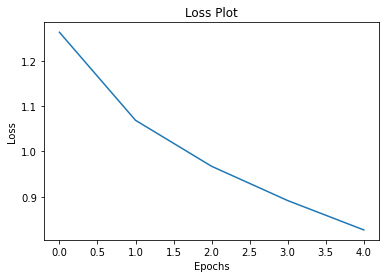

In [127]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [61]:
def evaluate(image):
   attention_plot = np.zeros((max_length, attention_features_shape))

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot

In [62]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

BELU score: 5.614021910443866e-76
Real Caption: Two white dogs are playing in the snow
Prediction Caption: four white dogs run in the snow


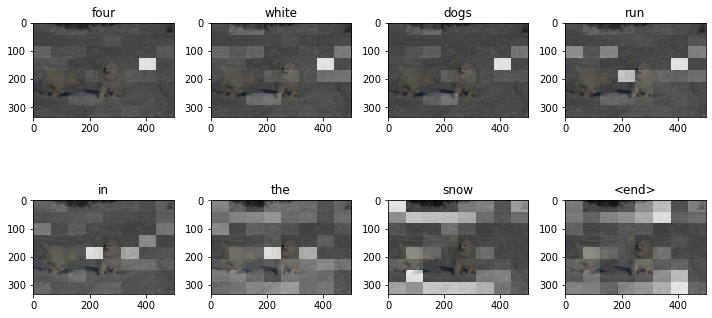

In [33]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = 'C:\\Users\\R SHREYA\\Desktop\\Mini project\\Flickr8k_Dataset/Flicker8k_Dataset/2319175397_3e586cfaf8.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = 'Two white dogs are playing in the snow'
first = real_caption.split(' ', 1)[1]


#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

Real Caption: two brown and white dogs fighting on grassy area in front of tree
Prediction Caption: two dogs run in front of wooden fence


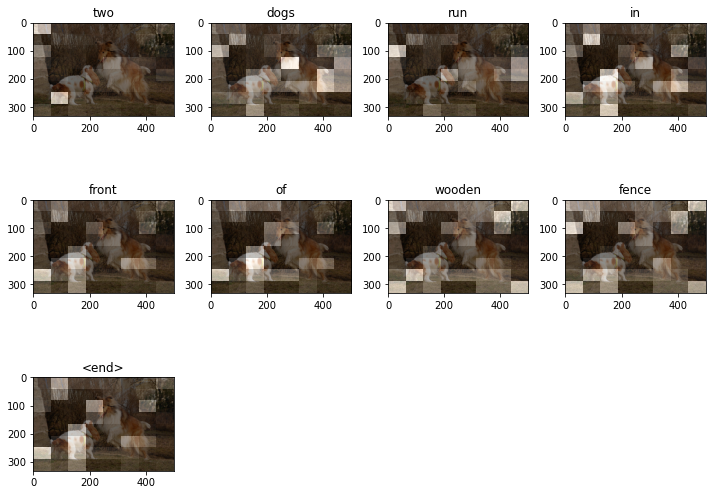

time took to Predict: 1 sec


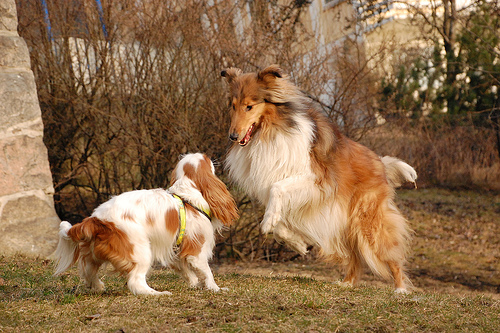

In [34]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])

BLEU score: 1.1200407237786664e-229
Prediction Caption: group of people are on fire


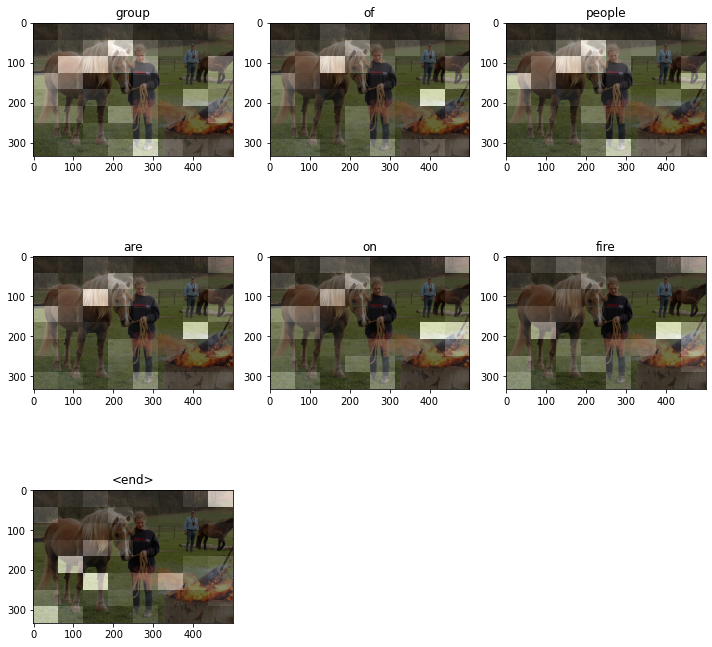

In [36]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = 'C:\\Users\\R SHREYA\\Desktop\\Mini project\\Flickr8k_Dataset/Flicker8k_Dataset/10815824_2997e03d76.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = 'Two white dogs are playing '
first = real_caption.split(' ', 1)[1]


#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BLEU score: {score*100}")

# print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

In [38]:
from gtts import gTTS

In [ ]:
import sys
print(sys.executable)



In [39]:

text = "realcaptionis"+real_caption
predict="predictedcaptionis"+result_final
tts = gTTS(predict)
tts.save("output.mp3")


In [40]:
from IPython.display import Audio
Audio("output.mp3", autoplay=True)

In [ ]:
for i in range(0,6):
  rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[rid]

  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
  for i in result:
    if i=="<unk>":
       result.remove(i)

  for i in real_caption:
    if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result
  result_join = ' '.join(result)
  result_final = result_join.rsplit(' ', 1)[0]

  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = result

  score = sentence_bleu(reference, candidate)
  print(f"BELU score: {score*100}")

  print ('Real Caption:', real_caption)
  print ('Prediction Caption:', result_final)

  plot_attention(image, result, attention_plot)
  Image.open(img_name_val[rid])



In [51]:
from gtts import gTTS
import streamlit as st
from PIL import Image
import io

def text_to_audio(text):
    tts = gTTS(text, lang='en')
    audio_fp = io.BytesIO()
    tts.write_to_fp(audio_fp)
    audio_fp.seek(0)
    return audio_fp

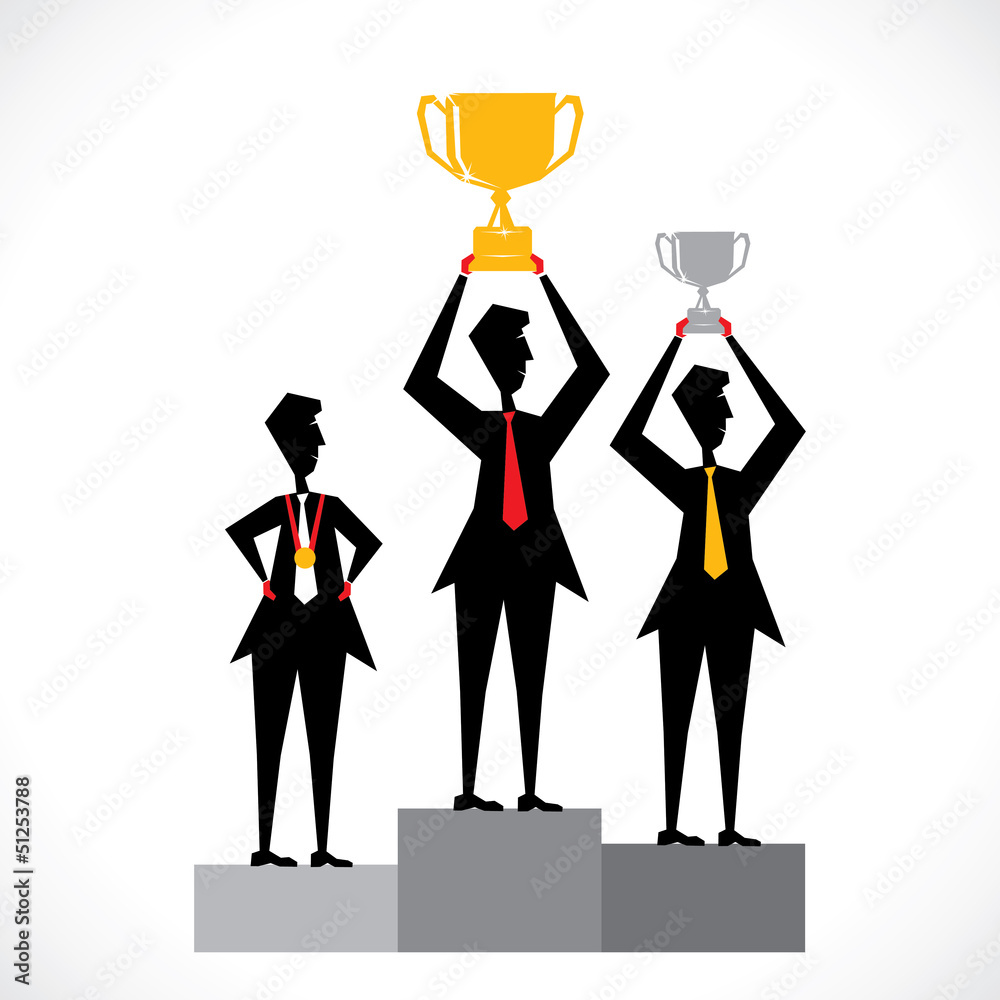

Caption: two people are standing on the sun


HTML(value='<audio controls="controls"><source src="data:audio/mp3;base64,//OExAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA…

In [136]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
from io import BytesIO
from gtts import gTTS
import base64

import numpy as np
import tensorflow as tf

# Placeholder function for image captioning
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)

    # Prepare image tensor for model input
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # Encode image features
    features = encoder(img_tensor_val)

    # Initialize decoder input with <start> token
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    # Generate caption
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        # Get predicted word ID
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        # Break if <end> token is predicted
        if tokenizer.index_word[predicted_id] == '<end>':
            break

        # Prepare next decoder input
        dec_input = tf.expand_dims([predicted_id], 0)

    # Trim attention plot to actual sequence length
    attention_plot = attention_plot[:len(result), :]

    return result, attention_plot


# Function to convert text to speech and return as base64
def text_to_speech(text):
    tts = gTTS(text)
    audio_fp = BytesIO()
    tts.write_to_fp(audio_fp)
    audio_fp.seek(0)
    audio_base64 = base64.b64encode(audio_fp.read()).decode()
    return audio_base64

# Function to handle image upload and processing
def on_upload_change(change):
    clear_output(wait=True)
    
    for filename, uploaded_file in change['new'].items():
        # Save uploaded file temporarily
        temp_filename = os.path.join('C:\\Users\\R SHREYA\\Downloads/', filename)
        with open(temp_filename, 'wb') as f:
            f.write(uploaded_file['content'])
        
        # Display the uploaded image
        image = Image.open(temp_filename)
        display(image)
        
        # Generate the caption
        try:
            result, attention_plot = evaluate(temp_filename)
            caption = ' '.join(result).rsplit(' ', 1)[0]  # Adjust based on your captioning logic
            print(f"Caption: {caption}")
            
            # Convert caption to speech
            audio_base64 = text_to_speech(caption)
            
            # Embed audio in HTML and display
            audio_html = f'<audio controls="controls"><source src="data:audio/mp3;base64,{audio_base64}" type="audio/mp3" /></audio>'
            display(widgets.HTML(audio_html))
        except Exception as e:
            print(f"Error generating caption: {e}")

# Create file uploader widget
uploader = widgets.FileUpload(accept='image/*', multiple=False)
uploader.observe(on_upload_change, names='value')

# Display uploader
display(uploader)